In [1]:
import pandas as pd
import numpy as np
import pyodbc
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d

import requests
import folium

In [2]:
# Configuración de los parámetros de conexión
server = 'localhost\\SQLEXPRESS'  # O el punto '.' que usaste en SSMS
database = 'EM_CUNBOY'

# Cadena de conexión usando Autenticación de Windows (Trusted_Connection)
conn_str = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'Trusted_Connection=yes;'
)


In [3]:
query = "select * from dbo.estaciones_full;"
conn = pyodbc.connect(conn_str)
raw_data = pd.read_sql(query, conn)

conn.close()

C:\Users\User\AppData\Local\Temp\ipykernel_18004\341712462.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  raw_data = pd.read_sql(query, conn)


In [4]:
query = "select * from dbo.coordenadas_estaciones;"
conn = pyodbc.connect(conn_str)
coor = pd.read_sql(query, conn)
coor.drop(["tx_id"], axis=1, inplace=True)

conn.close()

C:\Users\User\AppData\Local\Temp\ipykernel_18004\2772575436.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  coor = pd.read_sql(query, conn)


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80635 entries, 0 to 80634
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   tx_id              80635 non-null  int64         
 1   codigo_estacion    80635 non-null  object        
 2   fecha_observacion  80635 non-null  datetime64[ns]
 3   sensor_pre         80635 non-null  object        
 4   sensor_vel         80635 non-null  object        
 5   sensor_dir         80635 non-null  object        
 6   sensor_tem         80635 non-null  object        
 7   presion            80635 non-null  float64       
 8   velocidad          80635 non-null  float64       
 9   direccion          80635 non-null  float64       
 10  temperatura        80635 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 6.8+ MB


# explo

## coordenadas

In [6]:
coor.apply(lambda df: f"{df["codigo_estacion"]}: ( {df["latitud"]} , {df["longitud"]} )", axis=1)

0     0035085080: ( 5.099 , -73.436 )
1     0035080050: ( 5.096 , -73.053 )
2     0024015300: ( 5.643 , -73.518 )
3     0035025060: ( 4.587 , -73.996 )
4     0024035503: ( 5.818 , -72.844 )
                   ...               
79     0021206980: ( 4.785 , -73.87 )
80    0023125160: ( 5.647 , -74.071 )
81    2401500080: ( 5.634 , -73.386 )
82    0021205660: ( 4.579 , -74.523 )
83    2403500084: ( 5.758 , -72.795 )
Length: 84, dtype: object

## registro fechas

In [7]:
# raw_data.groupby(["codigo_estacion", "fecha_observacion"])[["presion", "velocidad", "direccion", "temperatura"]].mean()

In [8]:
df = raw_data.copy()
df.drop("tx_id", axis=1, inplace=True)

In [9]:
print(df.shape)
df = df.groupby(["codigo_estacion", "fecha_observacion"])[["presion", "velocidad", "direccion", "temperatura"]].mean().reset_index()
print(df.shape)

(80635, 10)
(71991, 6)


In [10]:
df

,codigo_estacion,fecha_observacion,presion,velocidad,direccion,temperatura
0,0021195120,2025-12-01 00:00:00,855.3,1.3,301.0,19.4
1,0021195120,2025-12-01 01:00:00,856.3,1.3,23.0,18.9
2,0021195120,2025-12-01 02:00:00,857.1,2.3,32.0,18.6
3,0021195120,2025-12-01 03:00:00,857.4,2.5,30.0,18.4
4,0021195120,2025-12-01 04:00:00,857.8,1.0,356.0,18.0
...,...,...,...,...,...,...
71986,3507500133,2025-12-31 19:00:00,691.6,3.6,66.0,9.5
71987,3507500133,2025-12-31 20:00:00,691.4,2.8,70.0,9.1
71988,3507500133,2025-12-31 21:00:00,691.4,2.4,200.0,9.6
71989,3507500133,2025-12-31 22:00:00,691.6,1.4,226.0,9.8


In [11]:
# print(df.shape)
# print("-"*50)
# cols = ["sensor_pre", "sensor_vel", "sensor_dir", "sensor_tem"]
# for col in cols:
#     print(df[col].value_counts())
#     col_0 = df[col].value_counts().index[0]
#     df = df[df[col] == col_0].copy()
#     print("-"*50)
# print(df.shape)

In [12]:
estaciones = df["codigo_estacion"].unique()

In [13]:
# df = df.sort_values(["codigo_estacion", "fecha_observacion"]).reset_index(drop=True)
df = df.sort_values(["fecha_observacion", "codigo_estacion"]).reset_index(drop=True)

In [14]:
df["fecha_observacion"].diff().unique()

<TimedeltaArray>
[NaT, '0 days 00:00:00', '0 days 00:10:00']
Length: 3, dtype: timedelta64[ns]

In [15]:
# fecha_minima = pd.to_datetime("2025-12-15")
# df = df[df["fecha_observacion"] >= fecha_minima]

In [16]:
estaciones_ok = list()
n = 1
for estacion in estaciones:
    min_date = df.loc[df["codigo_estacion"] == estacion, "fecha_observacion"].min()
    max_date = df.loc[df["codigo_estacion"] == estacion, "fecha_observacion"].max()
    diff_temp = df.loc[df["codigo_estacion"] == estacion, "fecha_observacion"].diff().unique()
    rows_temp = df.loc[df["codigo_estacion"] == estacion].shape[0]
    # if len(diff_temp) == 2: 
    # if rows_temp == 744 and not estacion in ["0024035250", "0024035360"]:
    if rows_temp == 744:
    # if rows_temp == 408:
    # if min_date <= pd.to_datetime("2025-12-14") and len(diff_temp) == 2:
    # if rows_temp == 408 and not estacion in ["0024035250"]:
    # 0021205509
    # if True:
    # if not estacion in ["0021205509"]:
        print(n , estacion)
        estaciones_ok.append(estacion)
        for diff in diff_temp: print(">", diff)
        print("cantidad de registros: ", rows_temp)
        print("fecha min: ", min_date)
        print("fecha max: ", max_date)
        print("-"*50)
        n += 1

1 0021195120
> NaT
> 0 days 01:00:00
cantidad de registros:  744
fecha min:  2025-12-01 00:00:00
fecha max:  2025-12-31 23:00:00
--------------------------------------------------
2 0021195170
> NaT
> 0 days 01:00:00
cantidad de registros:  744
fecha min:  2025-12-01 00:00:00
fecha max:  2025-12-31 23:00:00
--------------------------------------------------
3 0021205660
> NaT
> 0 days 01:00:00
cantidad de registros:  744
fecha min:  2025-12-01 00:00:00
fecha max:  2025-12-31 23:00:00
--------------------------------------------------
4 0021205670
> NaT
> 0 days 01:00:00
cantidad de registros:  744
fecha min:  2025-12-01 00:00:00
fecha max:  2025-12-31 23:00:00
--------------------------------------------------
5 0021205940
> NaT
> 0 days 01:00:00
cantidad de registros:  744
fecha min:  2025-12-01 00:00:00
fecha max:  2025-12-31 23:00:00
--------------------------------------------------
6 0023125170
> NaT
> 0 days 01:00:00
cantidad de registros:  744
fecha min:  2025-12-01 00:00:00
fec

# Elevación

In [17]:
def obtener_alturas_batch(coordenadas):
    """
    Consulta la elevación de múltiples puntos usando la API de Open-Elevation.
    coordenadas: Lista de diccionarios [{'latitude': lat, 'longitude': lon}, ...]
    """
    url = "https://api.open-elevation.com/api/v1/lookup"
    payload = {"locations": coordenadas}
    
    try:
        response = requests.post(url, json=payload, timeout=20)
        if response.status_code == 200:
            return response.json()['results']
    except Exception as e:
        print(f"Error al consultar la API: {e}")
    return None

In [18]:
puntos = list()
for idx in range(len(coor)):
    puntos.append({"latitude": coor.loc[idx, "latitud"], "longitude": coor.loc[idx, "longitud"]})
    ...

In [19]:
resultados = obtener_alturas_batch(puntos)

In [20]:
resultados_dics = {"latitud":list(), "longitud":list(), "altura":list()}
resultados

for resultado in resultados:
    resultados_dics["latitud"].append(resultado["latitude"])
    resultados_dics["longitud"].append(resultado["longitude"])
    resultados_dics["altura"].append(resultado["elevation"])

In [21]:
coor_alt = pd.DataFrame(resultados_dics)

In [22]:
print(f"rows: {df.shape[0]:,}")
wsdata = df.loc[df["codigo_estacion"].isin(estaciones_ok)].copy()
# wsdata.drop(["sensor_pre", "sensor_vel", "sensor_dir", "sensor_tem"], axis=1, inplace=True)
print(f"rows: {wsdata.shape[0]:,}")
print(f"{100 * wsdata.shape[0] / df.shape[0]:,.2f} %")

rows: 71,991
rows: 12,648
17.57 %


# WSDATA

In [23]:
wsdata.head()

,codigo_estacion,fecha_observacion,presion,velocidad,direccion,temperatura
0,0021195120,2025-12-01,855.3,1.3,301.0,19.4
1,0021195170,2025-12-01,718.9,2.5,141.0,12.9
11,0021205660,2025-12-01,922.4,0.8,209.0,23.9
12,0021205670,2025-12-01,809.1,1.0,47.0,17.2
15,0021205940,2025-12-01,746.6,0.6,241.0,10.3


In [24]:
wsdata = wsdata.sort_values(["codigo_estacion", "fecha_observacion"]).reset_index(drop=True)

In [25]:
wsdata["longitud"] = wsdata["codigo_estacion"].map(dict(zip(coor["codigo_estacion"], coor["longitud"])))
wsdata["latitud"] = wsdata["codigo_estacion"].map(dict(zip(coor["codigo_estacion"], coor["latitud"])))

In [26]:
wsdata = pd.merge(
    left=wsdata,
    right=coor_alt,
    how="left",
    on=["latitud", "longitud"]
)

In [27]:
wsdata.drop_duplicates(inplace=True)
wsdata.reset_index(drop=True, inplace=True)

In [28]:
wsdata.head()

,codigo_estacion,fecha_observacion,presion,velocidad,direccion,temperatura,longitud,latitud,altura
0,0021195120,2025-12-01 00:00:00,855.3,1.3,301.0,19.4,-74.393,4.393,1423.0
1,0021195120,2025-12-01 01:00:00,856.3,1.3,23.0,18.9,-74.393,4.393,1423.0
2,0021195120,2025-12-01 02:00:00,857.1,2.3,32.0,18.6,-74.393,4.393,1423.0
3,0021195120,2025-12-01 03:00:00,857.4,2.5,30.0,18.4,-74.393,4.393,1423.0
4,0021195120,2025-12-01 04:00:00,857.8,1.0,356.0,18.0,-74.393,4.393,1423.0


In [29]:
wsdata["fecha_observacion"].sort_values().diff().value_counts()

fecha_observacion
0 days 00:00:00    11904
0 days 01:00:00      743
Name: count, dtype: int64

In [30]:
fecha_inicio = wsdata["fecha_observacion"].min()
fecha_fin = wsdata["fecha_observacion"].max()
print(f"{fecha_inicio=} , {fecha_fin=}")
rango_tiempo = pd.date_range(fecha_inicio, fecha_fin, freq="10min").to_list()
estaciones_registradas = wsdata["codigo_estacion"].unique()
len(estaciones_registradas)


fecha_inicio=Timestamp('2025-12-01 00:00:00') , fecha_fin=Timestamp('2025-12-31 23:00:00')


17

In [31]:
wsdata["segundos"] = (wsdata["fecha_observacion"] - fecha_inicio) / np.timedelta64(1, 's')

In [32]:
wsdata["vel_u"] = wsdata.apply(lambda df: df["velocidad"] * np.sin(np.pi*(df["direccion"]/180)), axis=1)
wsdata["vel_v"] = wsdata.apply(lambda df: df["velocidad"] * np.cos(np.pi*(df["direccion"]/180)), axis=1)

In [33]:
wsdata = wsdata[[
    'codigo_estacion',
    'latitud',
    'longitud',
    'altura',
    'segundos',
    'presion',
    'vel_u',
    'vel_v',
    'temperatura',
]].copy()

## Filtrado WSData

In [34]:
# wsdata_filtrada = wsdata.loc[wsdata["presion"] < 775].copy()
# wsdata_filtrada = wsdata_filtrada.reset_index(drop=True)
# wsdata_filtrada.shape[0]

In [35]:
wsdata_filtrada = wsdata.copy()

## Interpolación WSData

In [36]:
wsdata_filtrada = wsdata_filtrada.sort_values(["codigo_estacion", "segundos"])

In [37]:
wsdata_filtrada.head()

,codigo_estacion,latitud,longitud,altura,segundos,presion,vel_u,vel_v,temperatura
0,0021195120,4.393,-74.393,1423.0,0.0,855.3,-1.114317,0.669549,19.4
1,0021195120,4.393,-74.393,1423.0,3600.0,856.3,0.507950,1.196656,18.9
2,0021195120,4.393,-74.393,1423.0,7200.0,857.1,1.218814,1.950511,18.6
3,0021195120,4.393,-74.393,1423.0,10800.0,857.4,1.250000,2.165064,18.4
4,0021195120,4.393,-74.393,1423.0,14400.0,857.8,-0.069756,0.997564,18.0


In [38]:
estaciones = wsdata_filtrada["codigo_estacion"].unique()

In [39]:
segundos_interpolados = np.arange(0, 2674800.0 + 1200, 1200)
wsdata_interpo_dict = dict()
wsdata_interpo_dict["codigo_estacion"] = np.array([])
wsdata_interpo_dict["segundos"] = np.array([])
wsdata_interpo_dict["presion"] = np.array([])
wsdata_interpo_dict["vel_u"] = np.array([])
wsdata_interpo_dict["vel_v"] = np.array([])
wsdata_interpo_dict["temperatura"] = np.array([])
wsdata_interpo_dict["latitud"] = np.array([])
wsdata_interpo_dict["longitud"] = np.array([])
wsdata_interpo_dict["altura"] = np.array([])

for estacion in estaciones:
    segundos = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "segundos"]
    presion = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "presion"]
    vel_u = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "vel_u"]
    vel_v = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "vel_v"]
    temperatura = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "temperatura"]
    
    latitud = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "latitud"]
    longitud = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "longitud"]
    altura = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "altura"]
    
    latitud = np.tile(latitud.values[0], len(segundos_interpolados))
    longitud = np.tile(longitud.values[0], len(segundos_interpolados))
    altura = np.tile(altura.values[0], len(segundos_interpolados))
    codigo_estacion = np.tile(estacion, len(segundos_interpolados))
    
    p_cubica = interp1d(segundos, presion, kind="cubic")
    u_cubica = interp1d(segundos, vel_u, kind="cubic")
    v_cubica = interp1d(segundos, vel_v, kind="cubic")
    t_cubica = interp1d(segundos, temperatura, kind="cubic")
    
    p_interpolada = p_cubica(segundos_interpolados)
    u_interpolada = u_cubica(segundos_interpolados)
    v_interpolada = v_cubica(segundos_interpolados)
    t_interpolada = t_cubica(segundos_interpolados)
    
    wsdata_interpo_dict["segundos"] = np.concat([wsdata_interpo_dict["segundos"], segundos_interpolados])
    
    wsdata_interpo_dict["presion"] = np.concat([wsdata_interpo_dict["presion"], p_interpolada])
    wsdata_interpo_dict["vel_u"] = np.concat([wsdata_interpo_dict["vel_u"], u_interpolada])
    wsdata_interpo_dict["vel_v"] = np.concat([wsdata_interpo_dict["vel_v"], v_interpolada])
    wsdata_interpo_dict["temperatura"] = np.concat([wsdata_interpo_dict["temperatura"], t_interpolada])
    
    wsdata_interpo_dict["latitud"] = np.concat([wsdata_interpo_dict["latitud"], latitud])
    wsdata_interpo_dict["longitud"] = np.concat([wsdata_interpo_dict["longitud"], longitud])
    wsdata_interpo_dict["altura"] = np.concat([wsdata_interpo_dict["altura"], altura])
    wsdata_interpo_dict["codigo_estacion"] = np.concat([wsdata_interpo_dict["codigo_estacion"], codigo_estacion])
    
    
    

In [40]:
wsdata_interpo_dict

{'codigo_estacion': array(['0021195120', '0021195120', '0021195120', ..., '2401500086',
        '2401500086', '2401500086'], shape=(37910,), dtype='<U32'),
 'segundos': array([0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06], shape=(37910,)),
 'presion': array([855.3       , 855.61674409, 855.95783972, ..., 738.30858452,
        738.43850843, 738.6       ], shape=(37910,)),
 'vel_u': array([-1.11431749, -0.40930029,  0.11885688, ...,  0.84757461,
         0.99622868,  0.78840949], shape=(37910,)),
 'vel_v': array([ 0.6695495 ,  0.80369828,  0.98267241, ..., -1.73654632,
        -1.69252592, -2.05387694], shape=(37910,)),
 'temperatura': array([19.4       , 19.21222124, 19.04533255, ..., 13.78316754,
        13.61507054, 13.3       ], shape=(37910,)),
 'latitud': array([4.393, 4.393, 4.393, ..., 5.554, 5.554, 5.554], shape=(37910,)),
 'longitud': array([-74.393, -74.393, -74.393, ..., -73.355, -73.355, -73.355],
       shape=(37910,)),
 'altura': arra

In [41]:
wsdata_interpo = pd.DataFrame(wsdata_interpo_dict)

In [42]:
wsdata_interpo.head()

,codigo_estacion,segundos,presion,vel_u,vel_v,temperatura,latitud,longitud,altura
0,0021195120,0.0,855.300000,-1.114317,0.669549,19.400000,4.393,-74.393,1423.0
1,0021195120,1200.0,855.616744,-0.409300,0.803698,19.212221,4.393,-74.393,1423.0
2,0021195120,2400.0,855.957840,0.118857,0.982672,19.045333,4.393,-74.393,1423.0
3,0021195120,3600.0,856.300000,0.507950,1.196656,18.900000,4.393,-74.393,1423.0
4,0021195120,4800.0,856.619938,0.795777,1.435834,18.776890,4.393,-74.393,1423.0


# Exploración datos

In [43]:
wsdata["segundos"].values.reshape(wsdata["codigo_estacion"].nunique() , -1)

array([[      0.,    3600.,    7200., ..., 2667600., 2671200., 2674800.],
       [      0.,    3600.,    7200., ..., 2667600., 2671200., 2674800.],
       [      0.,    3600.,    7200., ..., 2667600., 2671200., 2674800.],
       ...,
       [      0.,    3600.,    7200., ..., 2667600., 2671200., 2674800.],
       [      0.,    3600.,    7200., ..., 2667600., 2671200., 2674800.],
       [      0.,    3600.,    7200., ..., 2667600., 2671200., 2674800.]],
      shape=(17, 744))

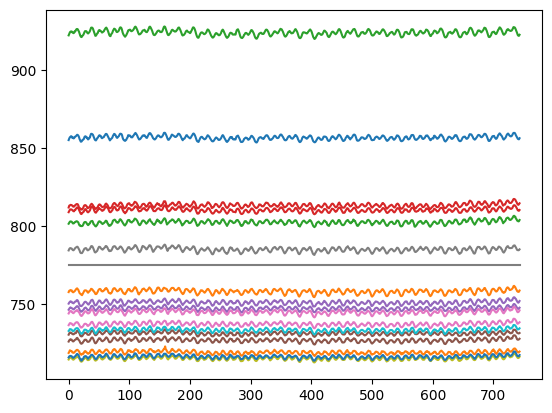

In [44]:
P = wsdata["presion"].values.reshape(wsdata["codigo_estacion"].nunique() , -1)
for idx in range(len(P)):
    plt.plot(P[idx,:])
plt.plot([775]*P[idx,:].shape[0])
plt.show()

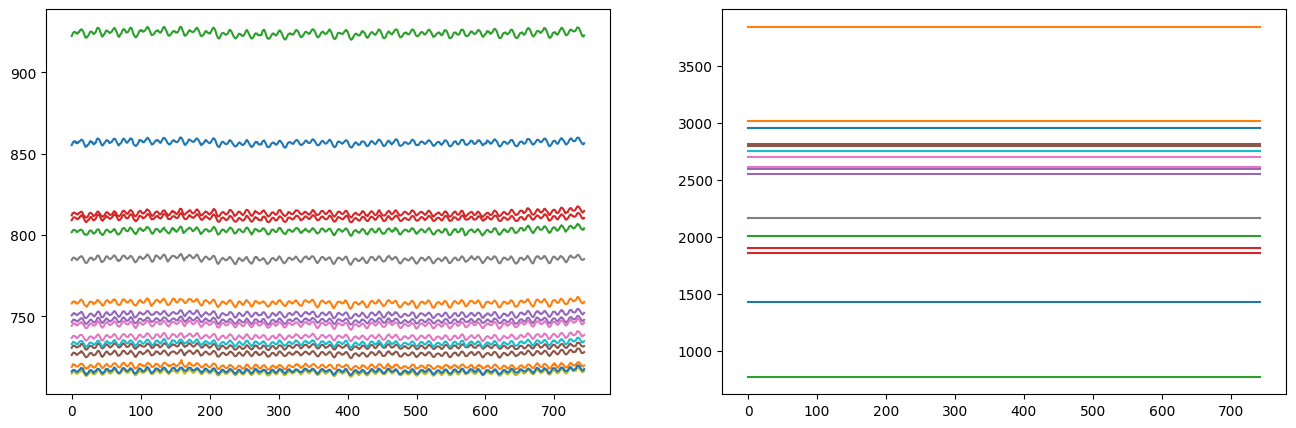

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

A = wsdata["presion"].values.reshape(wsdata["codigo_estacion"].nunique() , -1)
B = wsdata["altura"].values.reshape(wsdata["codigo_estacion"].nunique() , -1)

for idx in range(len(P)):
    ax[0].plot(A[idx,:])
    ax[1].plot(B[idx,:])
    
    
plt.show()

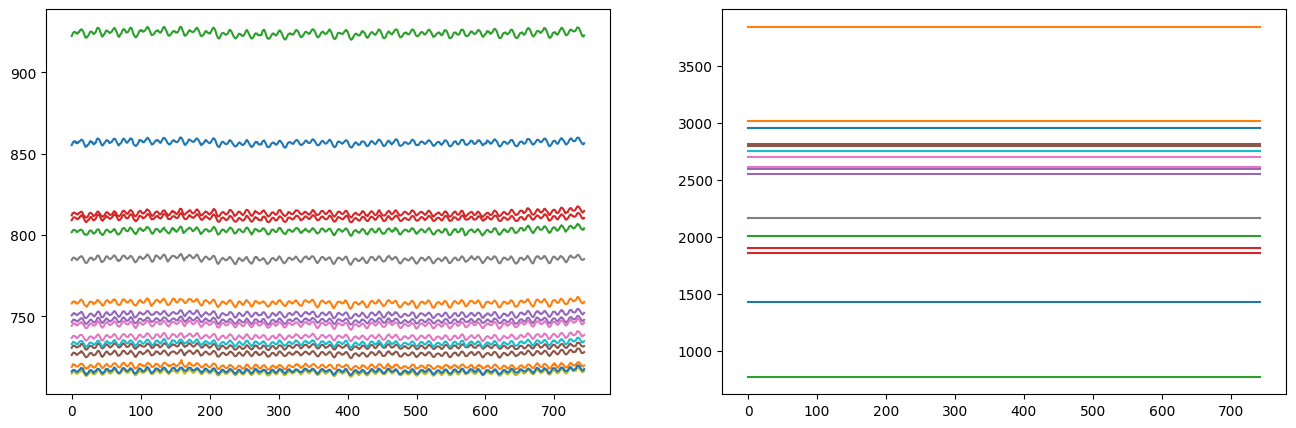

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

A = wsdata_filtrada["presion"].values.reshape(wsdata_filtrada["codigo_estacion"].nunique() , -1)
B = wsdata_filtrada["altura"].values.reshape(wsdata_filtrada["codigo_estacion"].nunique() , -1)

for idx in range(len(A)):
    ax[0].plot(A[idx,:])
    ax[1].plot(B[idx,:])
    
    
plt.show()

In [47]:
wsdata_filtrada["segundos"].values.reshape(wsdata_filtrada["codigo_estacion"].nunique() , -1)

array([[      0.,    3600.,    7200., ..., 2667600., 2671200., 2674800.],
       [      0.,    3600.,    7200., ..., 2667600., 2671200., 2674800.],
       [      0.,    3600.,    7200., ..., 2667600., 2671200., 2674800.],
       ...,
       [      0.,    3600.,    7200., ..., 2667600., 2671200., 2674800.],
       [      0.,    3600.,    7200., ..., 2667600., 2671200., 2674800.],
       [      0.,    3600.,    7200., ..., 2667600., 2671200., 2674800.]],
      shape=(17, 744))

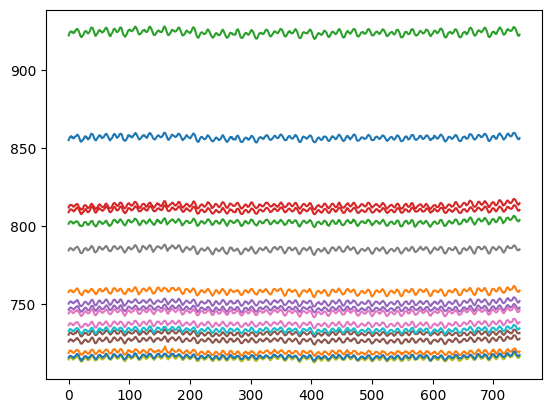

In [48]:
P = wsdata_filtrada["presion"].values.reshape(wsdata_filtrada["codigo_estacion"].nunique() , -1)
for idx in range(len(P)):
    plt.plot(P[idx,:])
# plt.plot([775]*P[idx,:].shape[0])
plt.show()

In [49]:
wsdata_interpo["segundos"].values.reshape(wsdata_interpo["codigo_estacion"].nunique() , -1)

array([[0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       ...,
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06]], shape=(17, 2230))

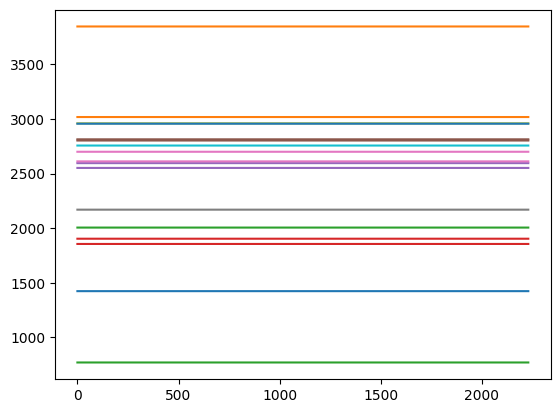

In [50]:
P = wsdata_interpo["altura"].values.reshape(wsdata_interpo["codigo_estacion"].nunique() , -1)
for idx in range(len(P)):
    plt.plot(P[idx,:])
# plt.plot([775]*P[idx,:].shape[0])
plt.show()

# Completar fechas con NaN

In [51]:
# estaciones_registradas = wsdata["codigo_estacion"].unique()
# estaciones = list()
# latitudes = list()
# longitudes = list()
# alturas = list()

# for estacion in estaciones_registradas:
#     estaciones += [estacion]*len(rango_tiempo)
#     latitudes += [wsdata.loc[wsdata["codigo_estacion"] == estacion, "latitud"].unique()[0]]*len(rango_tiempo)
#     longitudes += [wsdata.loc[wsdata["codigo_estacion"] == estacion, "longitud"].unique()[0]]*len(rango_tiempo)
#     alturas += [wsdata.loc[wsdata["codigo_estacion"] == estacion, "altura"].unique()[0]]*len(rango_tiempo)
    
#     ...

# fechas = rango_tiempo * len(estaciones_registradas)

In [52]:
# base_estacion_fechas = pd.DataFrame({"codigo_estacion":estaciones, "fecha_observacion":fechas, "latitud":latitudes, "longitud":longitudes, "altura":alturas})
# wsdata_full = pd.merge(left=base_estacion_fechas, right=wsdata, on=["codigo_estacion", "fecha_observacion", "latitud", "longitud", "altura"], how="left")

In [53]:
# wsdata_full.head()

In [54]:
# wsdata_full = wsdata_full.sort_values(["codigo_estacion", "fecha_observacion"]).reset_index(drop=True)

In [55]:
# wsdata_full["vel_u"] = wsdata_full.apply(lambda df: df["velocidad"] * np.sin(np.pi*(df["direccion"]/180)), axis=1)
# wsdata_full["vel_v"] = wsdata_full.apply(lambda df: df["velocidad"] * np.cos(np.pi*(df["direccion"]/180)), axis=1)

In [56]:
# wsdata_full["segundos"] = (wsdata_full["fecha_observacion"] - fecha_inicio) / np.timedelta64(1, 's')

In [57]:
# wsdata_full = wsdata_full[[
#     'codigo_estacion',
#     'latitud',
#     'longitud',
#     'altura',
#     'segundos',
#     'presion',
#     'vel_u',
#     'vel_v',
#     'temperatura',
# ]].copy()

In [58]:
# wsdata_full.sample(5)

In [59]:
# path_save_wsdata = Path().cwd().parent / "data" / "raw" / "em_bgta_251201_251231.parquet"
# path_save_wsdata_full = Path().cwd().parent / "data" / "raw" / "em_bgta_251201_251231_full.parquet"
# wsdata.to_parquet(path_save_wsdata, engine="fastparquet", index=False)
# wsdata_full.to_parquet(path_save_wsdata_full, engine="fastparquet", index=False)

# Exportar

In [60]:
wsdata.tail()

,codigo_estacion,latitud,longitud,altura,segundos,presion,vel_u,vel_v,temperatura
12643,2401500086,5.554,-73.355,2699.0,2660400.0,737.9,8.316468e-01,-3.912590,17.6
12644,2401500086,5.554,-73.355,2699.0,2664000.0,737.6,1.455362e+00,-2.737138,17.3
12645,2401500086,5.554,-73.355,2699.0,2667600.0,737.9,3.673940e-16,-3.000000,14.9
12646,2401500086,5.554,-73.355,2699.0,2671200.0,738.2,5.080360e-01,-2.037621,13.9
12647,2401500086,5.554,-73.355,2699.0,2674800.0,738.6,7.884095e-01,-2.053877,13.3


In [61]:
wsdata_filtrada.tail()

,codigo_estacion,latitud,longitud,altura,segundos,presion,vel_u,vel_v,temperatura
12643,2401500086,5.554,-73.355,2699.0,2660400.0,737.9,8.316468e-01,-3.912590,17.6
12644,2401500086,5.554,-73.355,2699.0,2664000.0,737.6,1.455362e+00,-2.737138,17.3
12645,2401500086,5.554,-73.355,2699.0,2667600.0,737.9,3.673940e-16,-3.000000,14.9
12646,2401500086,5.554,-73.355,2699.0,2671200.0,738.2,5.080360e-01,-2.037621,13.9
12647,2401500086,5.554,-73.355,2699.0,2674800.0,738.6,7.884095e-01,-2.053877,13.3


In [62]:
wsdata_interpo.tail()

,codigo_estacion,segundos,presion,vel_u,vel_v,temperatura,latitud,longitud,altura
37905,2401500086,2670000.0,738.102527,0.143202,-2.447433,14.061277,5.554,-73.355,2699.0
37906,2401500086,2671200.0,738.200000,0.508036,-2.037621,13.900000,5.554,-73.355,2699.0
37907,2401500086,2672400.0,738.308585,0.847575,-1.736546,13.783168,5.554,-73.355,2699.0
37908,2401500086,2673600.0,738.438508,0.996229,-1.692526,13.615071,5.554,-73.355,2699.0
37909,2401500086,2674800.0,738.600000,0.788409,-2.053877,13.300000,5.554,-73.355,2699.0


In [63]:
path_save_wsdata = Path().cwd().parent / "data" / "raw" / "em_cundinamarca_boyaca_251201_251231.parquet"
wsdata.to_parquet(path_save_wsdata, engine="fastparquet", index=False)


In [64]:
path_save_wsdata_filtrada = Path().cwd().parent / "data" / "raw" / "em_cundinamarca_boyaca_251201_251231_11ws.parquet"
wsdata_filtrada.to_parquet(path_save_wsdata_filtrada, engine="fastparquet", index=False)


In [65]:
path_save_wsdata_interpo = Path().cwd().parent / "data" / "raw" / "em_cundinamarca_boyaca_251201_251231_11ws_interpo.parquet"
wsdata_interpo.to_parquet(path_save_wsdata_interpo, engine="fastparquet", index=False)
